<a href="https://colab.research.google.com/github/supervladimir/ML_AirCanada/blob/main/ML_and_Air_Canada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\# Math 5990: Topics in Information Theory Final Project
# By Vlad Zaitsev

The purpose of this project is to create a neural network to predict the future price of stocks. In this project, we have focused on one specific Canadian-based airline company, Air Canada, however, this can be easily modified to provide predictions for any other company listed on the New York or Toronto stock exchange.

Below are the python libraries that will be used to build the model.

In [9]:
import numpy as np
import time as tm
import datetime as dt
import pandas_datareader.data as web
import pandas as pd

# Data preparation
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

# Graphics library
import matplotlib.pyplot as plt

The following code cell defines two important parameters.


1.   N_STEPS defines how many days of data will be used in order to make predictions and train the model.
2.   LOOKUP_STEPS defines the models that we will build. For example, a '1' will correspond to a model that can predict one business day ahead. A '15' corresponds to a model that will be able to predict 15 business days ahead (3 weeks of trading).


In [15]:
# Window size/sequence length (BUSINESS DAYS)
N_STEPS = 25

# These are the days to predict 1 is the next day, 2 = after tomorrow (Days to predict)
LOOKUP_STEPS = [15,20,30,40]

STOCK = 'AC.TO'

# Number of days not fed to model
N_FORECAST_DAYS = 0

The following code cell now defines the amount of days for which we will collect data to be used for training. The amount of days is easily changed, however, note that the number of days also counts weekends. So 7 days of data will only actually capture 5 days of trading.

For these dates, we collect the price history of Air Canada, as well as five macroeconomic and airline specific sector indicators, which include:


1.   WTI oil price
2.   USD/CAD exchange rates
3.   Price history of JETS ETF (ETF containing many publicly traded airline
companies)
4.   S&P/TSX Composite Index
5.   Canadian prime interest rates

Each of these are closely tied to the price of Air Canada. Specifically, oil prices and USD/CAD exchange rates directly influence the companies earnings, while the JETS ETF, S&P/TSX Composite Index and the Canadian prime rate show the health of the economy and help capture the state of the economic market.

We only include days for which Air Canada is traded, even if other data is available.

In [16]:
# Dates for data
date_now = tm.strftime('%Y-%m-%d')
date_1700_days = (dt.date.today() - dt.timedelta(days=1700)).strftime('%Y-%m-%d')
date_1740_days = (dt.date.today() - dt.timedelta(days=1740)).strftime('%Y-%m-%d')

# LOAD DATA
init_df = yf.download(
    STOCK,
    start=date_1700_days,
    end=date_now,
    interval='1d')
init_df = init_df[['Close']].rename(columns={"Close": "AirCanada_Close"})

init_df2 = yf.download(
    "CL=F",
    start=date_1700_days,
    end=date_now,
    interval='1d')
init_df2 = init_df2[['Close']].rename(columns={"Close": "WTI_Oil_Price"})

init_df3 = yf.download(
    "CAD=X",
    start=date_1700_days,
    end=date_now,
    interval='1d')
init_df3 = init_df3[['Close']].rename(columns={"Close": "USD_CAD_Rate"})

init_df4 = yf.download(
    "JETS",
    start=date_1700_days,
    end=date_now,
    interval='1d')
init_df4 = init_df4[['Close']].rename(columns={"Close": "Airline_Index"})

init_df5 = yf.download(
    "^GSPTSE",
    start=date_1700_days,
    end=date_now,
    interval='1d')
init_df5 = init_df5[['Close']].rename(columns={"Close": "TSX_Index"})

#unemp = web.DataReader("LRUNTTTTCAM156S", "fred", start=date_1740_days, end=date_now)
#full_idx = pd.date_range(start=unemp.index.min(), end=date_now, freq="D")
#unemp_daily = (
#    unemp
#    .reindex(full_idx)
#    .ffill()
#    .rename(columns={"LRUNTTTTCAM156S": "Canada_Unemployment"})
#)
interest = web.DataReader("IR3TIB01CAM156N", "fred", start=date_1740_days, end=date_now)
full_idx = pd.date_range(start=interest.index.min(), end=date_now, freq="D")
interest_rates = (
    interest
    .reindex(full_idx)
    .ffill()
    .rename(columns={"IR3TIB01CAM156N": "Canada_PrimeRate"})
)


combined = init_df.join(
    [init_df2, init_df3, init_df4, init_df5, interest_rates],
    how="left"     # keeps all rows from `ac` (i.e. days AC traded)
).sort_index()

combined = combined.ffill()

missing = combined.isna().sum()
print("NaNs after ffill:\n", missing)

# Renaming columns
combined.columns = [col[0] if isinstance(col, tuple) else col
                           for col in combined.columns]

print("New columns:", combined.columns.tolist())
feature_cols = ['AirCanada_Close','WTI_Oil_Price',
                'USD_CAD_Rate','Airline_Index','TSX_Index','Canada_PrimeRate']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

NaNs after ffill:
 (AirCanada_Close, AC.TO)    0
(WTI_Oil_Price, CL=F)       0
(USD_CAD_Rate, CAD=X)       0
(Airline_Index, JETS)       0
(TSX_Index, ^GSPTSE)        0
Canada_PrimeRate            0
dtype: int64
New columns: ['AirCanada_Close', 'WTI_Oil_Price', 'USD_CAD_Rate', 'Airline_Index', 'TSX_Index', 'Canada_PrimeRate']


Below is the combined dataframe that contains all of our data.

In [17]:
combined

,AirCanada_Close,WTI_Oil_Price,USD_CAD_Rate,Airline_Index,TSX_Index,Canada_PrimeRate
Date,,,,,,
2020-09-30,15.690000,40.220001,1.33838,16.780781,16121.400391,0.142
2020-10-01,15.950000,38.720001,1.33053,16.999228,16184.500000,0.100
2020-10-02,15.640000,37.049999,1.32840,17.207747,16199.299805,0.100
2020-10-05,15.500000,39.220001,1.32910,17.336828,16410.199219,0.100
2020-10-06,15.520000,40.669998,1.32570,17.048876,16236.099609,0.100
...,...,...,...,...,...,...
2025-05-20,18.790001,62.560001,1.39569,22.570000,26055.599609,2.622
2025-05-21,18.360001,61.570000,1.39093,21.879999,25839.199219,2.622
2025-05-22,18.620001,61.200001,1.38608,22.100000,25854.000000,2.622


We now scale the collected data to integers between 0 and 1. The scalers differ for each of our indicators, and are stored to be used to inverse the scaling once the model has made its predictions.

In [18]:
#Scaling Data
scalers = {}
combined_scaled = pd.DataFrame(index=combined.index)
for col in combined.columns:
    scaler_col = MinMaxScaler(feature_range=(0, 1))
    combined_scaled[col] = scaler_col.fit_transform(combined[[col]])
    scalers[col] = scaler_col


Below is our data in which each column has been scaled.

In [27]:
combined_scaled

,AirCanada_Close,WTI_Oil_Price,USD_CAD_Rate,Airline_Index,TSX_Index,Canada_PrimeRate
Date,,,,,,
2020-09-30,0.168533,0.050392,0.502352,0.148108,0.051418,0.016824
2020-10-01,0.183854,0.033330,0.473050,0.163962,0.057417,0.008462
2020-10-02,0.165586,0.014333,0.465099,0.179095,0.058824,0.008462
2020-10-05,0.157336,0.039017,0.467712,0.188463,0.078876,0.008462
2020-10-06,0.158515,0.055511,0.455021,0.167565,0.062323,0.008462
...,...,...,...,...,...,...
2025-05-20,0.351208,0.304516,0.716275,0.568258,0.995931,0.510602
2025-05-21,0.325869,0.293254,0.698507,0.518181,0.975356,0.510602
2025-05-22,0.341190,0.289046,0.680403,0.534148,0.976763,0.510602


Here is a plot of our scaled data.

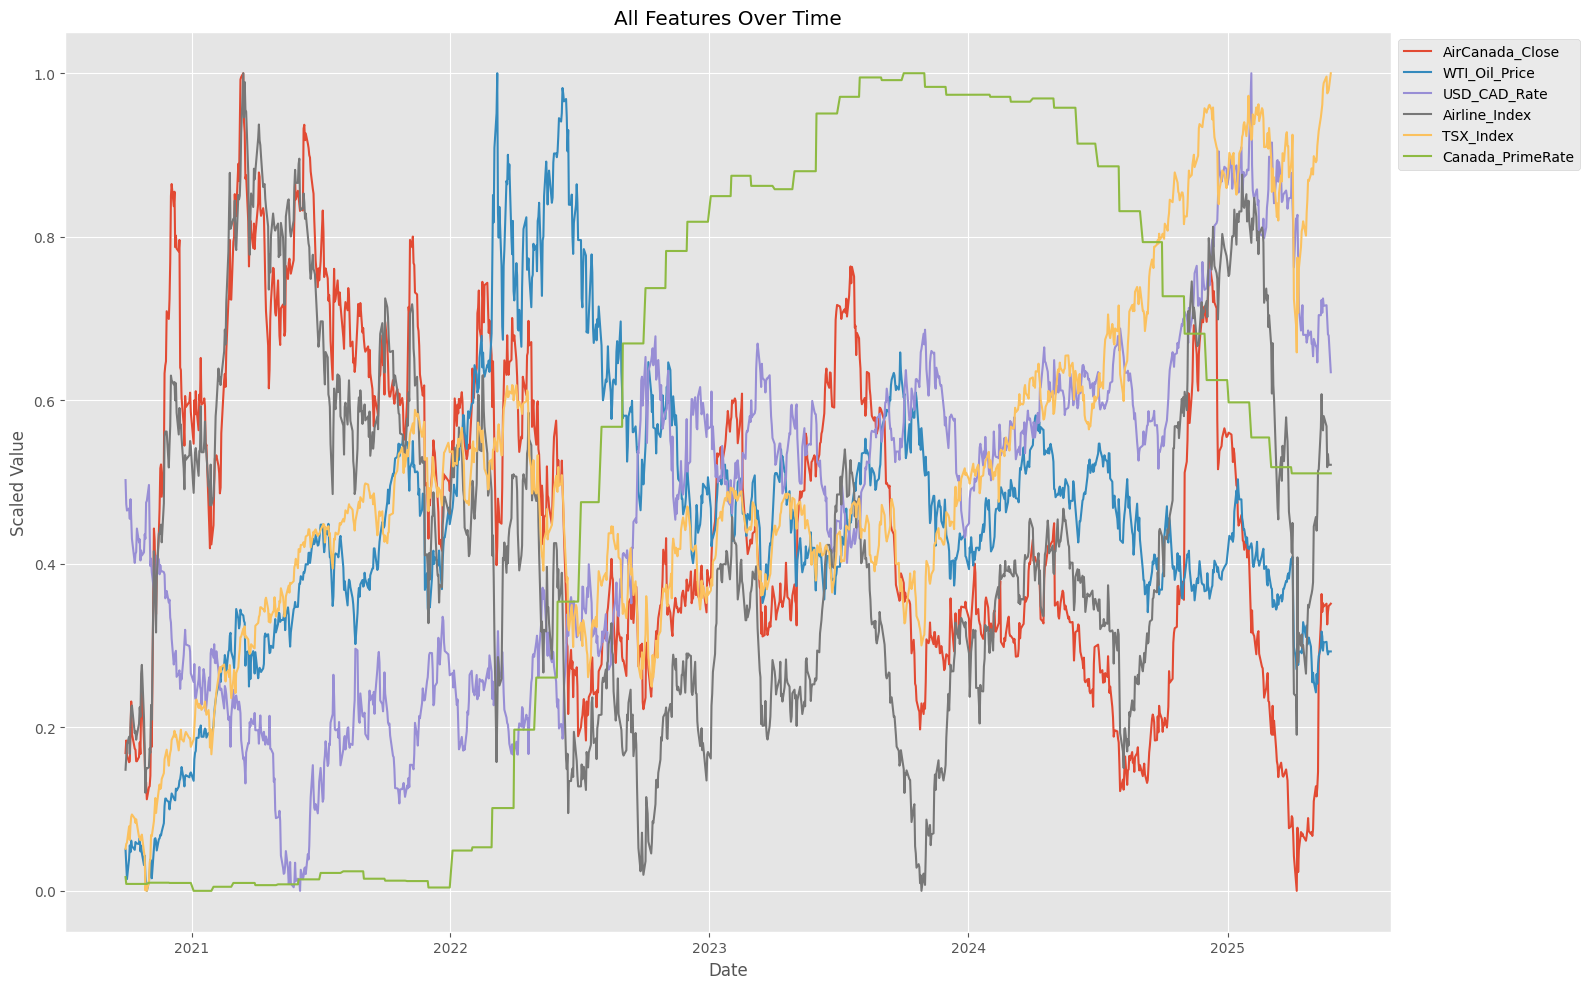

In [28]:
plt.style.use('ggplot')
plt.figure(figsize=(16, 10))

# Loop through every column in `combined` and plot it
for col in combined_scaled.columns:
    plt.plot(combined_scaled.index, combined_scaled[col], label=col)

plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('All Features Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

The previous plot is quite messy, so we have included 5 seperate plots to see the effect of each of our indicators on the share price of Air Canada.

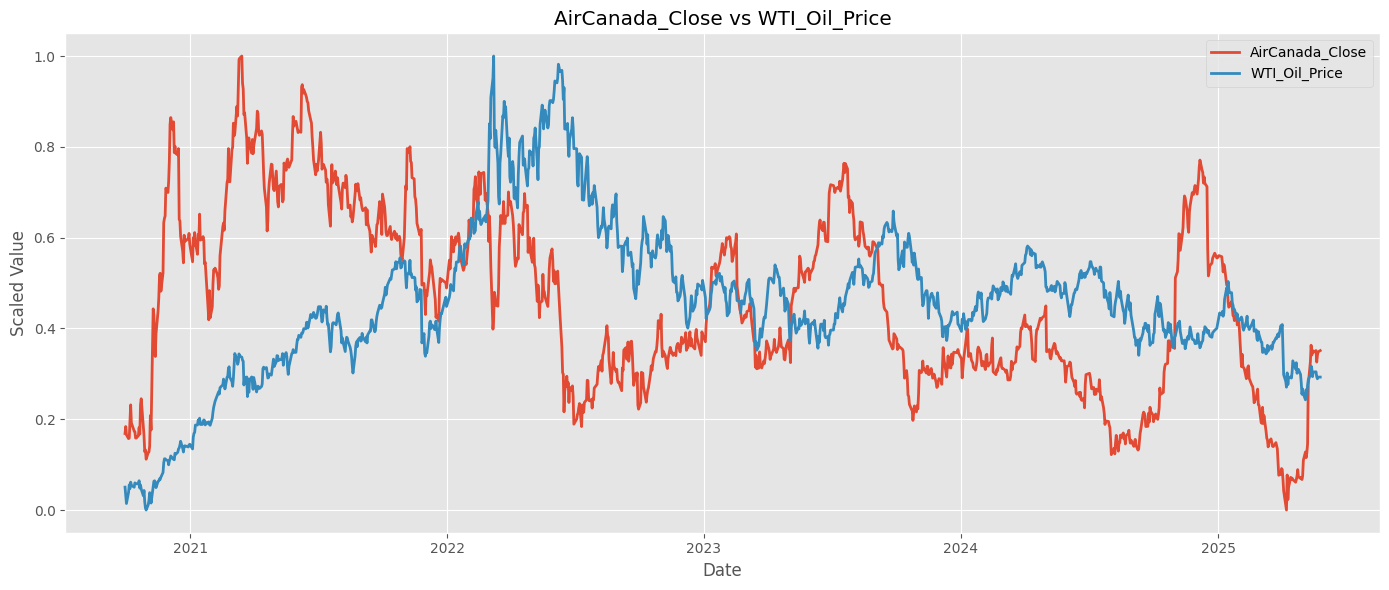

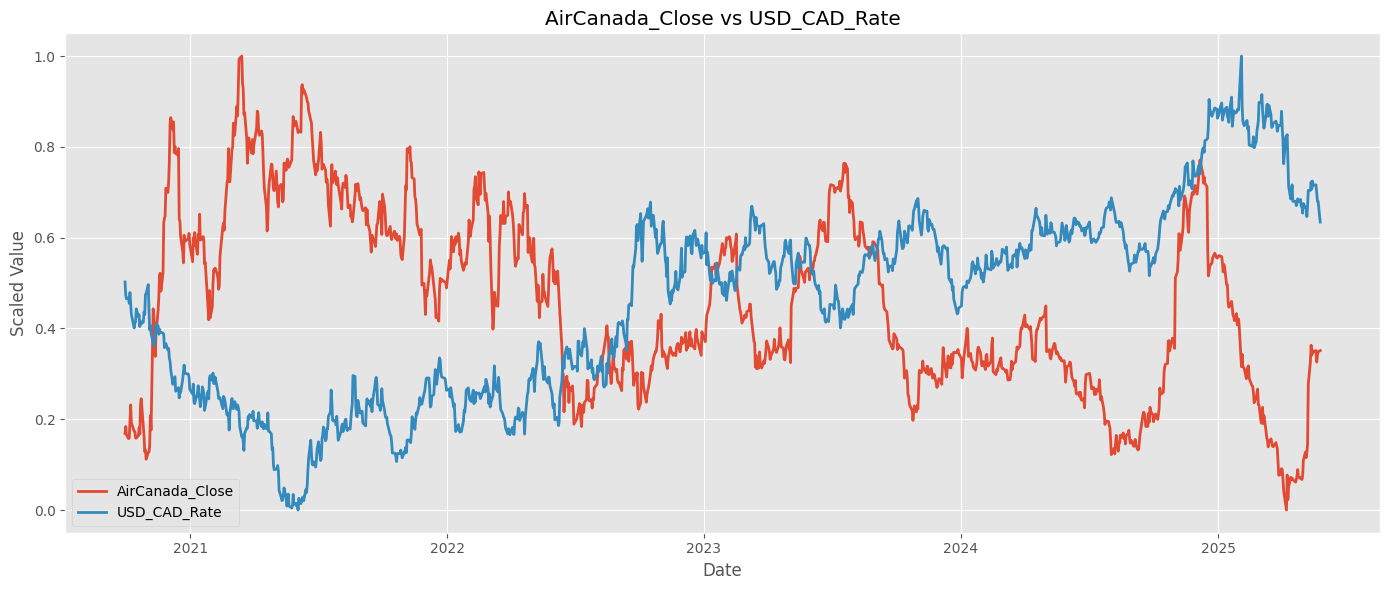

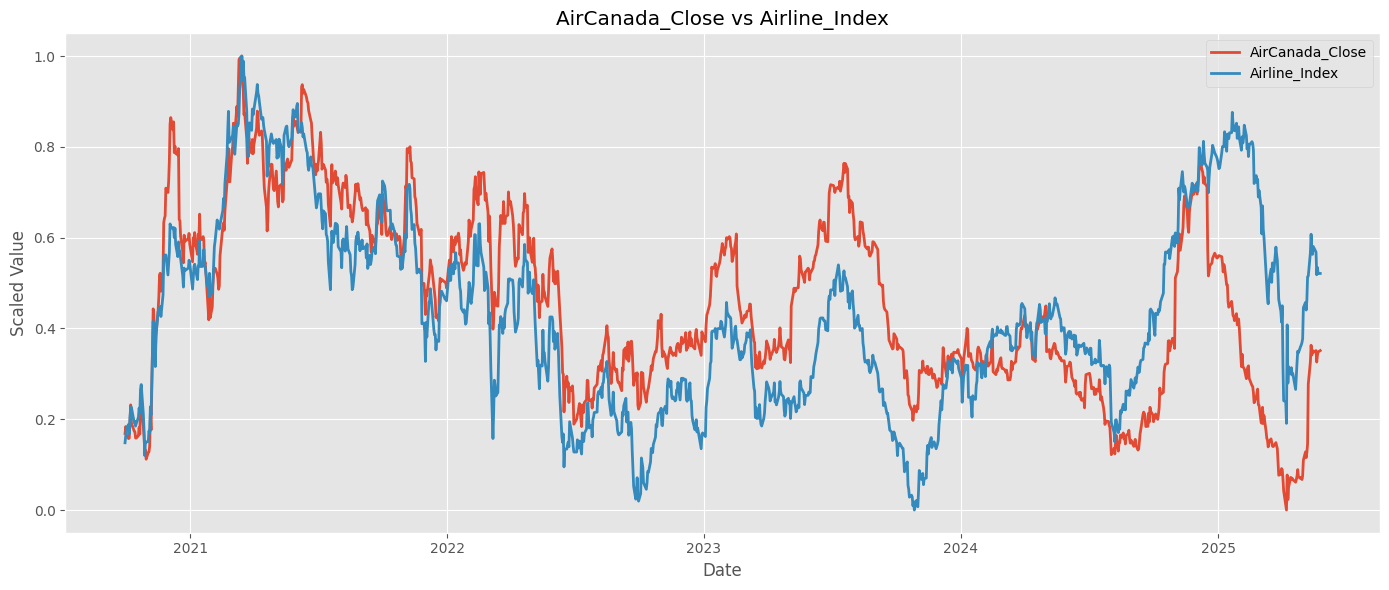

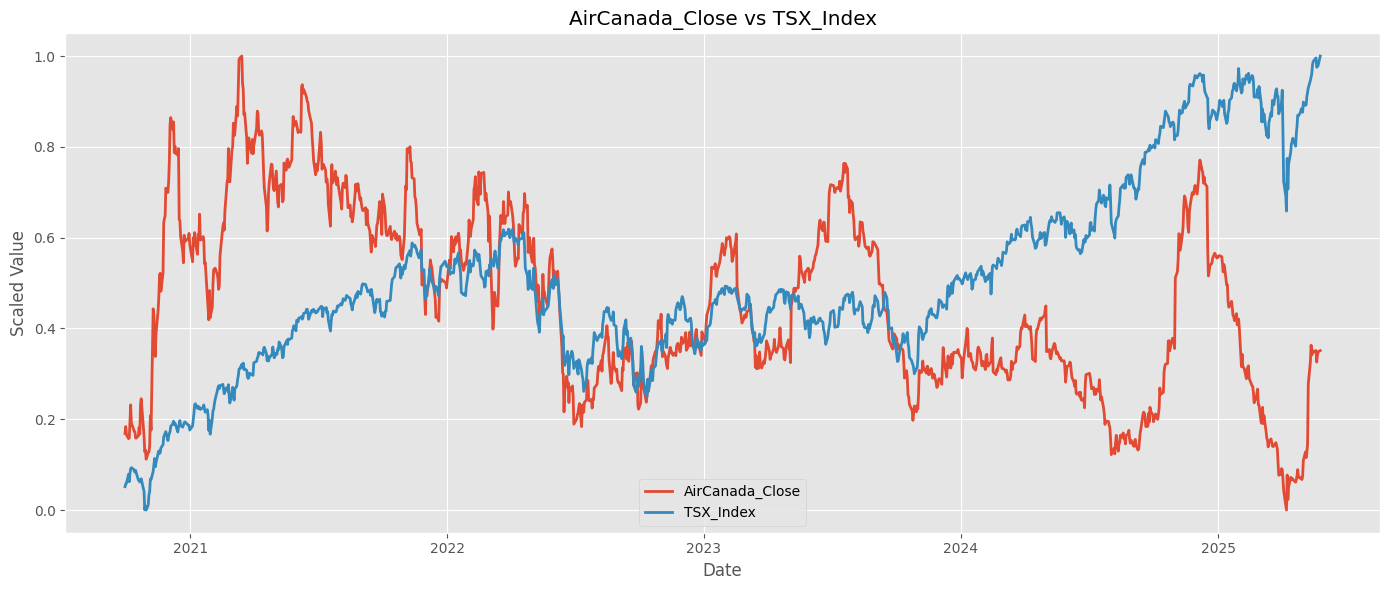

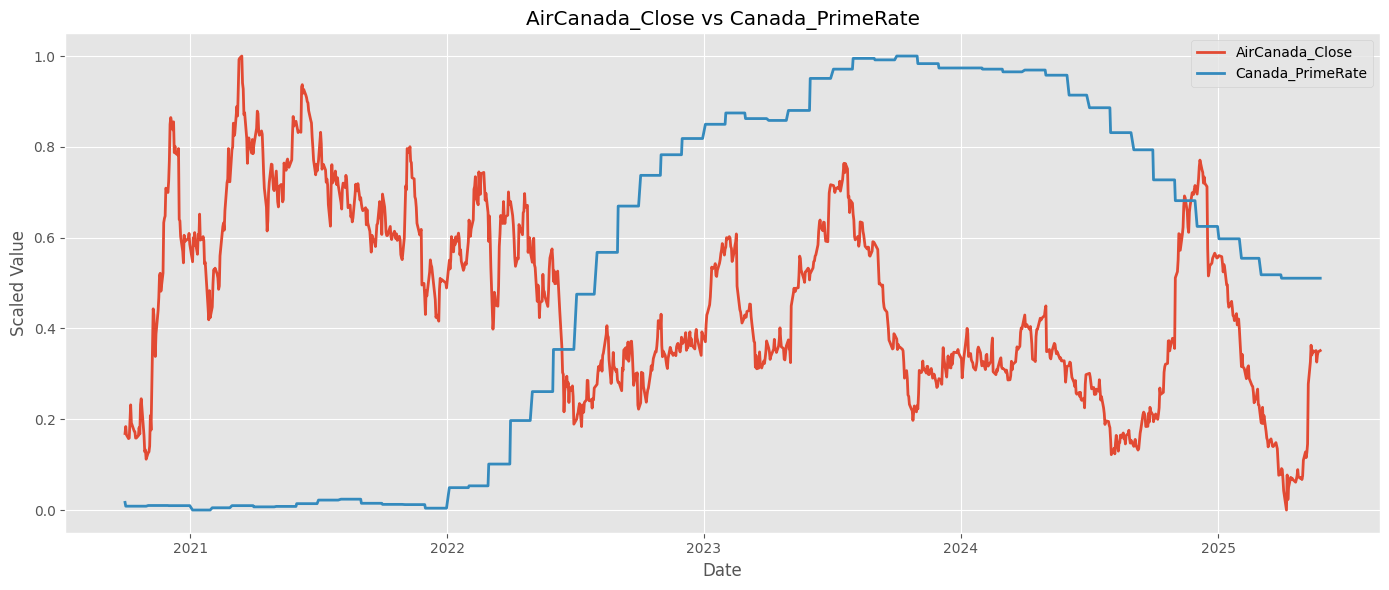

In [29]:
features = [
    "WTI_Oil_Price",
    "USD_CAD_Rate",
    "Airline_Index",
    "TSX_Index",
    "Canada_PrimeRate"
]

for feature in features:
    plt.figure(figsize=(14, 6))
    plt.plot(combined_scaled.index, combined_scaled["AirCanada_Close"],
             label="AirCanada_Close", linewidth=2)
    plt.plot(combined_scaled.index, combined_scaled[feature],
             label=feature, linewidth=2)
    plt.title(f"AirCanada_Close vs {feature}")
    plt.xlabel("Date")
    plt.ylabel("Scaled Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

We are now ready to create our model. We now define three important functions.

The first function, PrepareData, is responsible for preparing our scaled data for training. This function returns points (x,y) to be used for training, as well as the last sequence(s) which will be used to make future predictions.

In [30]:
from collections import deque
import numpy as np
def PrepareData(days, df, feature_cols):
    data = df.copy()

    data['future'] = data[feature_cols[0]]

    data.dropna(inplace=True)

    # Build X, Y to build model
    sequences = deque(maxlen=N_STEPS)
    X, Y = [], []

    for row in data[feature_cols].values:
        sequences.append(row)
        if len(sequences) == N_STEPS:
            X.append(np.array(sequences))
    for i in range(N_STEPS+days-1,len(data)):
      Y.append(data['future'].iloc[i])

    Y.append(df['AirCanada_Close'].iloc[len(X)])
    X = np.array(X)
    Y = np.array(Y)

    #last sequences for forecasting
    last_seq = []
    data = data.iloc[:-1]
    Y = np.delete(Y, -1)
    for i in range(days):
      seq = X[-1]
      last_seq.append(seq)
      X = X[:-1]
    last_seq.reverse()
    last_seq = np.array(last_seq)

    return data, last_seq, X, Y

The next function, GetTrainedModel, actually defines our model and its parameters. For this project, we are creating a sequential LTSM model with 2 layers LSTM(64) and LSTM(128).

These parameters can be easily changed to alter the behaviour of the program. The node sizes of 64 and 128 were chosen in order to provide a balance between the model being able to process and recognize complex patters in our data and not having the model become over-trained from our data.

BATCH_SIZE defines the number of data points the model is given to train, while EPOCHS defines the maximum number of renditions our model is allowed to train.

The errors are defined by Huber, with parameter δ set to 0.01 (1%). Huber allows us to use both mean squared error for small errors (which minimizes their impact as they are <1) and absolute error for larger errors which are then penalized more heavily.

All of these parameters can be easily changed to alter the complexity and predictive abilities of the model.

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(N_STEPS, len(combined_scaled.columns))))
  model.add(Dropout(0.2))
  model.add(LSTM(128, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 16
  EPOCHS = 80

  model.compile(loss=Huber(delta=0.01), optimizer='adam')
  #model.compile(loss='mean_squared_error', optimizer='adam')
  #model.compile(loss='mean_absolute_error', optimizer='adam')
  early_stop = EarlyStopping(
        monitor='val_loss',      # quantity to be monitored
        patience=15,             # number of epochs with no improvement
        restore_best_weights=True  # roll back to best weights
  )
  history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,   # reserve 10% of data for validation
        callbacks=[early_stop],
        verbose=1
  )

  model.summary()

  return model

The final code cell necessary to build our predictions then uses the function PrepareData to first prepare the training data, and then send this data to the second function GetTrainedModel to actually build this model.

Each model is then stored in models to be used for backtesting and to make future predictions.

In [32]:
models = {}
predictions = []
for step in LOOKUP_STEPS:
    # Prepare data
    df_trimmed, last_seq, x_train, y_train = PrepareData(
        days=step,
 #       df=combined_scaled[:-N_FORECAST_DAYS],
        df=combined_scaled,
        feature_cols=feature_cols
    )

    x_train = x_train.astype(np.float32)

    #Train model
    m = GetTrainedModel(x_train, y_train)
    models[step] = m
    y_pred_scaled = m.predict(last_seq)

    y_pred_original = scalers["AirCanada_Close"].inverse_transform(y_pred_scaled)

    predictions.append(float(y_pred_original[step-1,0]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 2/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 9.6162e-04 - val_loss: 0.0020
Epoch 3/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 9.0197e-04 - val_loss: 0.0020
Epoch 4/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 8.6578e-04 - val_loss: 0.0018
Epoch 5/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 8.3191e-04 - val_loss: 0.0022
Epoch 6/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 8.6877e-04 - val_loss: 0.0019
Epoch 7/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 8.3307e-04 - val_loss: 0.0021
Epoch 8/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 7.7480e-04 - val_loss: 0.0015
Epoch 9/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.1635e-04 - val_loss: 0.0019
Epoch 10/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 7.7695e-04 - val_loss: 0.0021
Epoch 11/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 7.9588e-04 - val_loss: 0.0025
Epoch 12/80
64/64 ━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,781 (1.37 MB)

 Trainable params: 119,593 (467.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 239,188 (934.33 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 2/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 3/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 9.3247e-04 - val_loss: 0.0021
Epoch 4/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 9.1524e-04 - val_loss: 0.0018
Epoch 5/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 8.8501e-04 - val_loss: 0.0019
Epoch 6/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 8.6926e-04 - val_loss: 0.0020
Epoch 7/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 8.3112e-04 - val_loss: 0.0018
Epoch 8/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 8.4565e-04 - val_loss: 0.0020
Epoch 9/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8.9147e-04 - val_loss: 0.0020
Epoch 10/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 8.4398e-04 - val_loss: 0.0023
Epoch 11/80
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 9.2873e-04 - val_loss: 0.0022
Epoch 12/80
64/64 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 25, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,781 (1.37 MB)

 Trainable params: 119,593 (467.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 239,188 (934.33 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.7056e-04 - val_loss: 0.0028
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 9.7766e-04 - val_loss: 0.0026
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 8.9291e-04 - val_loss: 0.0032
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.9282e-04 - val_loss: 0.0025
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 9.2993e-04 - val_loss: 0.0021
Epoch 9/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8.7775e-04 - val_loss: 0.0029
Epoch 10/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 8.7660e-04 - val_loss: 0.0023
Epoch 11/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 9.0344e-04 - val_loss: 0.0021
Epoch 12/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 25, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,781 (1.37 MB)

 Trainable params: 119,593 (467.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 239,188 (934.33 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 2/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 3/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 4/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 5/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 8.9699e-04 - val_loss: 0.0030
Epoch 6/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 8.9994e-04 - val_loss: 0.0028
Epoch 7/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 9.3424e-04 - val_loss: 0.0026
Epoch 8/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 9.1114e-04 - val_loss: 0.0025
Epoch 9/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.7005e-04 - val_loss: 0.0023
Epoch 10/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.7292e-04 - val_loss: 0.0026
Epoch 11/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 9.0684e-04 - val_loss: 0.0028
Epoch 12/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 25, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,781 (1.37 MB)

 Trainable params: 119,593 (467.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 239,188 (934.33 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step


Once the model is trained we can easily see the models predictions for each element of LOOKUP_STEPS. In our case we obtain stock price predictions 1 day, 1 week, 3 weeks and 6 weeks from the most recent trading day.

In [10]:
predictions

[17.9232120513916, 18.99407958984375, 22.402111053466797, 22.65139389038086]

Finally, we can backtest each of our models to see how the predictions stack up to the actual price of the stock.

The plots also include price forecasts for 1, 5, 15 and 30 days in the future, respective to each model.

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


<ipython-input-37-a053d6628702>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions2.append(float(df_preds['predicted_close'][-1]))


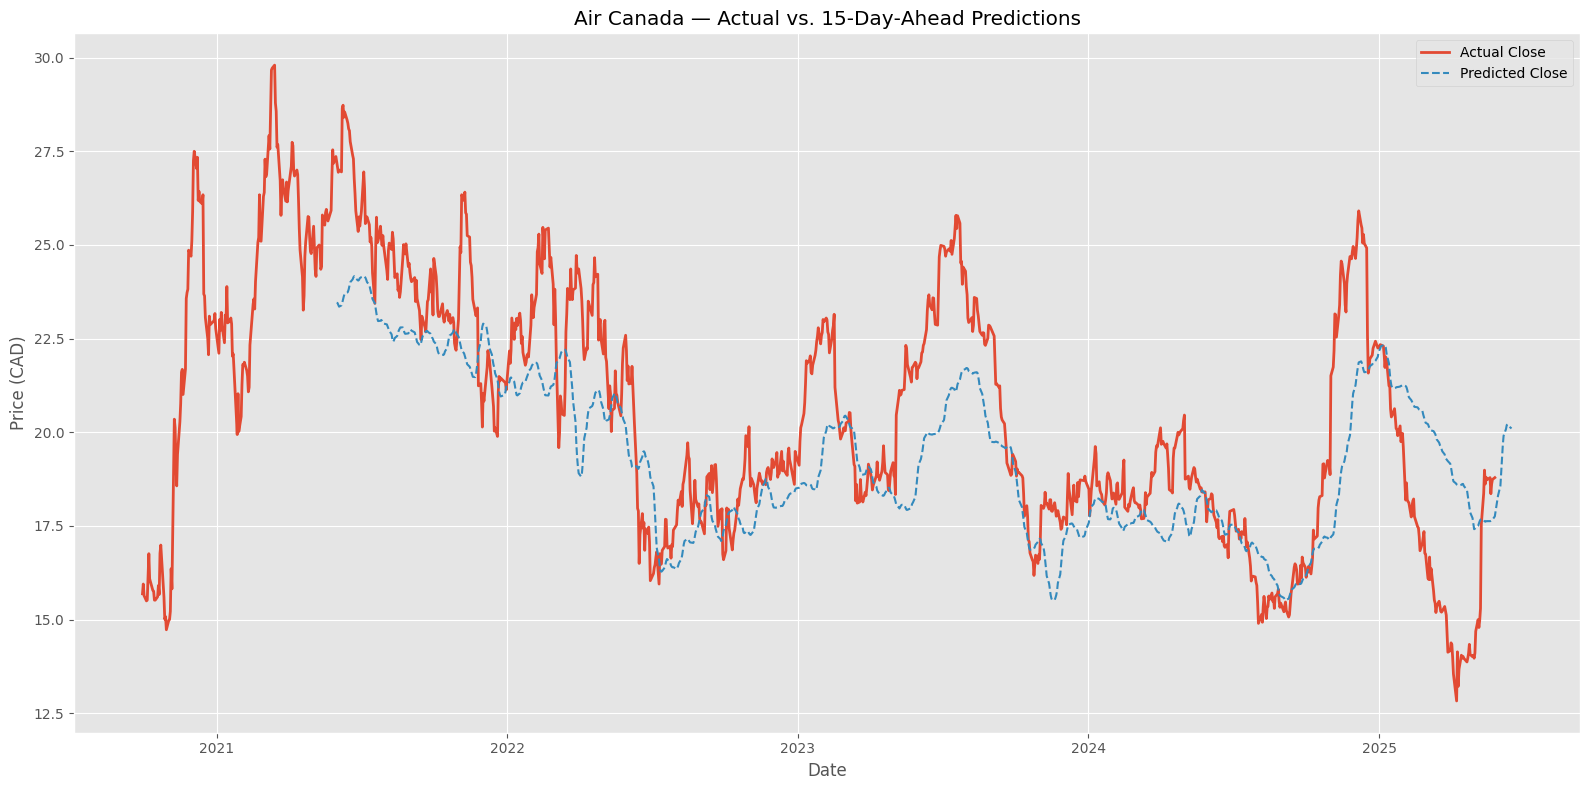

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


<ipython-input-37-a053d6628702>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions2.append(float(df_preds['predicted_close'][-1]))


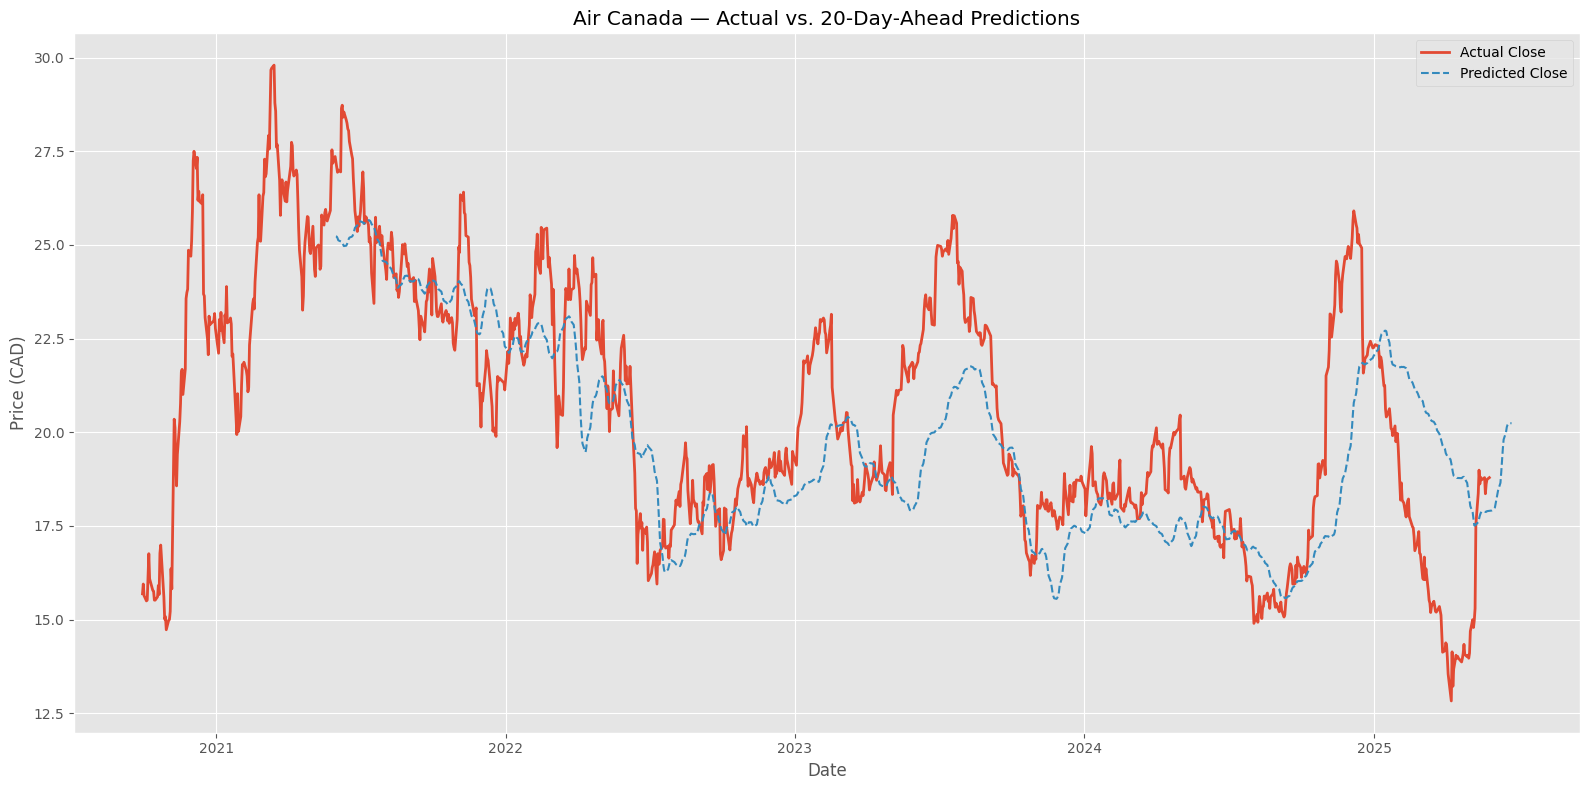

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


<ipython-input-37-a053d6628702>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions2.append(float(df_preds['predicted_close'][-1]))


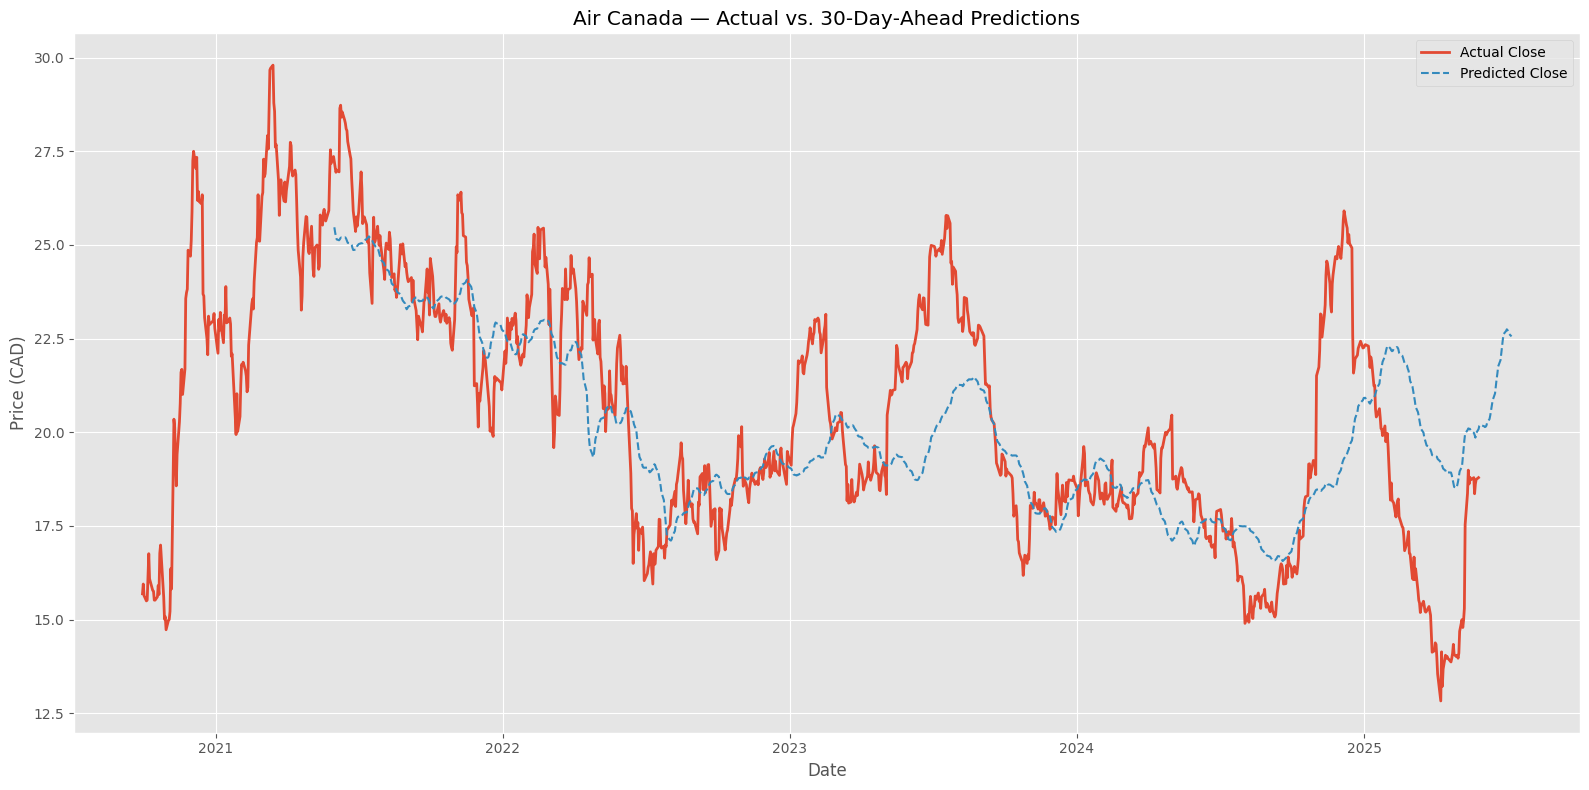

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<ipython-input-37-a053d6628702>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions2.append(float(df_preds['predicted_close'][-1]))


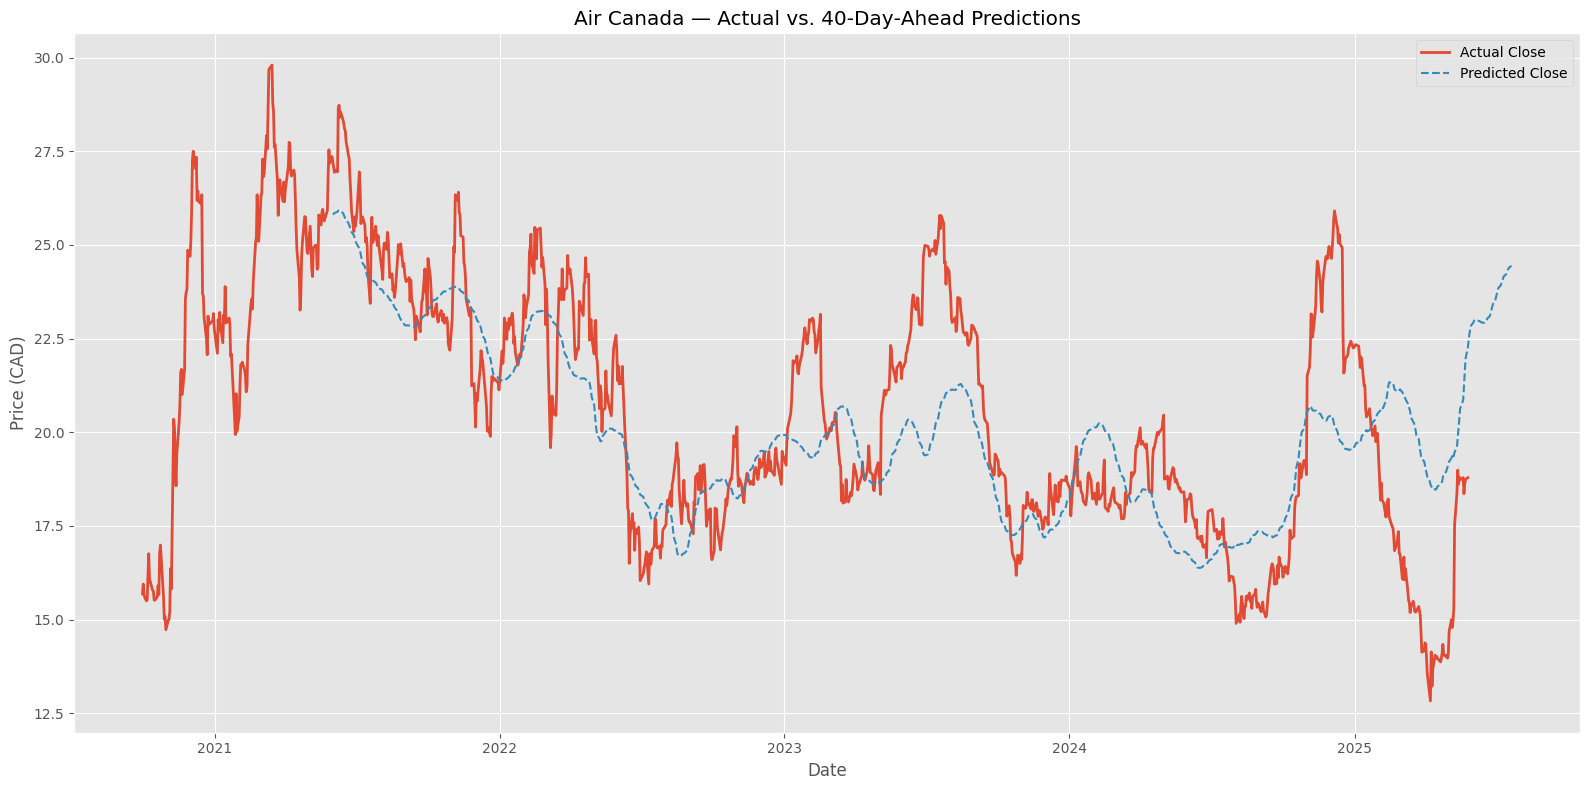

In [37]:
from pandas.tseries.offsets import BDay
from IPython.display import clear_output
count = 0
predictions2 = []
for step in LOOKUP_STEPS:
    df_h, last, X_h, y = PrepareData(
        days=LOOKUP_STEPS[count],
        df=combined_scaled,
        feature_cols=feature_cols
    )
    X_h = X_h.astype(np.float32)

    # Predictions
    y_scaled = models[step].predict(X_h)
    y_pred = scalers['AirCanada_Close'].inverse_transform(y_scaled)
    y_pred = y_pred.flatten()

    y_last_scaled = models[step].predict(last)
    y_last = scalers['AirCanada_Close'].inverse_transform(y_last_scaled)
    y_last = y_last.flatten()


    y_pred = np.append(y_pred, y_last)

    window_ends = df_h.index[N_STEPS+LOOKUP_STEPS[count]-1:]
    last_date = window_ends[-1]
    future_dates = []
    for i in range(LOOKUP_STEPS[count]+1):
      future_dates = pd.DatetimeIndex([last_date + BDay(i+1)])
      window_ends=window_ends.append(future_dates)

    df_preds = pd.DataFrame({
        'predicted_close': y_pred
    }, index=window_ends)

    plt.style.use('ggplot')
    plt.figure(figsize=(16, 8))

    # Plot the actual historical close
    plt.plot(
     #   combined['AirCanada_Close'][:-N_FORECAST_DAYS+1],
        combined['AirCanada_Close'],
        label='Actual Close',
        linewidth=2
    )

    # Plot the actual historical close NOT given to model
    plt.plot(
 #       combined['AirCanada_Close'][-N_FORECAST_DAYS:],
        label='Actual Close (not given to model)',
        linewidth=2
    )

    # Overlay of 1‑day‑ahead backtest + forecast
    plt.plot(
        df_preds['predicted_close'][-1000-LOOKUP_STEPS[count]:],
        linestyle='--',
        linewidth=1.5,
        label='Predicted Close'
    )
    predictions2.append(float(df_preds['predicted_close'][-1]))
    plt.xlabel('Date')
    plt.ylabel('Price (CAD)')
    plt.title(
    "Air Canada — Actual vs. "
    + str(LOOKUP_STEPS[count])
    + "‑Day‑Ahead Predictions")
    plt.legend()
    plt.tight_layout()
    plt.show()
    count = count + 1


In summary, we have created a modular, data-driven LTSM neural network that uses historical market and economic data to forecast future stock prices.

We used Air Canada for our demonstration, but the stock and data chosen can be easily altered to provide predictions for any other publicly trading company.

The specific capacities of the model can also be easily modified in order to change the behaviour and predictive capacity of each model, and allows for easy training of new models to predict for any number of trading days in the future.

The section below uses a Monte Carlo simulation to put in reference the model's predictions.

In [40]:
import time as tm
import datetime as dt
date_now = tm.strftime('%Y-%m-%d')
date_start = (dt.date.today() - dt.timedelta(days=8700)).strftime('%Y-%m-%d')

# loading data for entire history of Air Canada
df = yf.download(
    'AC.TO',
    start=date_start,
    end=date_now,
    interval='1d')
df = df[['Close']].rename(columns={"Close": "AirCanada_Close"})
df

[*********************100%***********************]  1 of 1 completed


Price,AirCanada_Close
Ticker,AC.TO
Date,
2010-03-30,2.220000
2010-03-31,2.220000
2010-04-01,2.450000
2010-04-05,2.520000
2010-04-06,2.550000
...,...
2025-05-20,18.790001
2025-05-21,18.360001


<ipython-input-57-ba3d58abefdb>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = logrets.mean()[0]               # sample mean of log‐returns
<ipython-input-57-ba3d58abefdb>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  v = ((logrets - m)**2).mean()[0]     # population variance, ddof=0


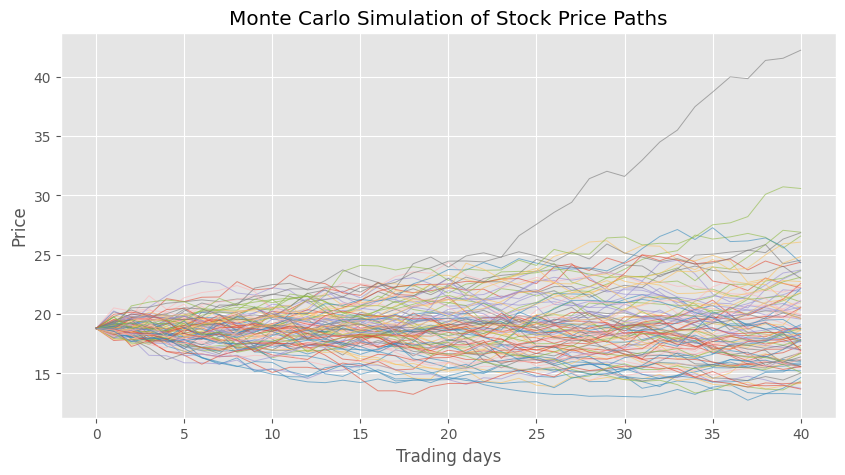

Max end $:  42.24842636024193
Min end $:  10.854480202609759
Mean end $:  19.494571270002698
Median end $:  19.085277553327593
Standard Deviation:  3.732100436695621


In [57]:
# MC simulations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

logrets = np.log(df['AirCanada_Close'] / df['AirCanada_Close'].shift(1)).dropna()

m = logrets.mean()[0]               # sample mean of log‐returns
v = ((logrets - m)**2).mean()[0]     # population variance, ddof=0
sigma = np.sqrt(v)
mu    = (m + 0.5 * v)

S0    = df['AirCanada_Close'].iloc[-1]  # last observed price is the start of the simulation
dt    = 1         # time step = 1 trading day
N_sim = 1000     # number of simulated paths
T = LOOKUP_STEPS[-1]

mc_paths = np.zeros((T + 1, N_sim))
mc_paths[0] = S0

for t in range(1, T + 1):
    Z = np.random.standard_normal(N_sim)
    mc_paths[t] = mc_paths[t-1]*np.exp(m*dt + sigma*np.sqrt(dt)*Z)

plt.figure(figsize=(10,5))
plt.plot(mc_paths[:, :100], linewidth=0.7, alpha=0.6)
plt.title('Monte Carlo Simulation of Stock Price Paths')
plt.xlabel('Trading days')
plt.ylabel('Price')
plt.show()

# plt.figure(figsize=(6,4))
# plt.hist(mc_paths[-1], bins=50, density=True, alpha=0.7)
# plt.title('Distribution of Simulated End Prices (Day {})'.format(T))
# plt.xlabel('Price')
# plt.ylabel('Density')
#plt.show()

print("Max end $: ",max(mc_paths[-1]))
print("Min end $: ",min(mc_paths[-1]))
print("Mean end $: ",np.mean(mc_paths[-1]))
print("Median end $: ",np.median(mc_paths[-1]))
print("Standard Deviation: ",np.std(mc_paths[-1]))

In [58]:
# MC profit calculator

import numpy as np
import pandas as pd

# last observed price
S0 = df['AirCanada_Close'].iloc[-1][0]

rows = []
for i, T in enumerate(LOOKUP_STEPS):
    mc_end = mc_paths[T]   # shape (N_sim,), end‐of‐period simulated prices
    p      = predictions2[i]    # your point forecast for T days ahead

    pct_below = np.mean(mc_end < p)
    direction = np.sign(p - S0)
    profit_paths = np.where(direction > 0, mc_end - S0, S0 - mc_end)   # If prediction for stock is up, then calculate profit/loss based on buying. Otherwise calculate profit/less on selling

    prob_profit = np.mean(profit_paths > 0)
    exp_profit  = np.mean(profit_paths)
    max_profit  = np.max(profit_paths)
    min_profit  = np.min(profit_paths)

    rows.append({
        'days': T,
        'forecast':   p,
        'pctile':     1-pct_below,
        'sim mean':   mc_end.mean(),
        'sim median': np.median(mc_end),
        'sim std':    mc_end.std(),
        'prob profit':prob_profit,
        'exp profit': exp_profit,
        'max profit': max_profit,
        'min profit': min_profit
    })

# build a DataFrame indexed by the horizon
metrics_df = pd.DataFrame(rows).set_index('days')
print(metrics_df)


       forecast  pctile   sim mean  sim median   sim std  prob profit  \
days                                                                    
15    20.103041   0.296  19.074672   18.922098  2.090955        0.531   
20    20.242249   0.311  19.173532   19.050654  2.445087        0.532   
30    22.559576   0.143  19.244025   19.034361  3.126803        0.535   
40    24.440601   0.099  19.494571   19.085278  3.732100        0.525   

      exp profit  max profit  min profit  
days                                      
15      0.284671    6.924540   -5.273174  
20      0.383531    8.058493   -5.664966  
30      0.454024   15.218043   -6.745883  
40      0.704570   23.458425   -7.935521  


<ipython-input-58-988ee8d77ed8>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = df['AirCanada_Close'].iloc[-1][0]
